In [1]:
import json
import urllib.request
from bs4 import BeautifulSoup
import pandas
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# description:
#   get tickers for the DOW 30 from the Yahoo Finance website (https://finance.yahoo.com/quote/%5EDJI/components/)
# args:
#   
# return:
#   tickers - array with all 30 tickers in the DOW 30
def get_dow_tickers():
    url = "https://finance.yahoo.com/quote/%5EDJI/components/"

    # get html
    fp = urllib.request.urlopen(url)
    mybytes = fp.read()
    html = mybytes.decode("utf8")
    fp.close()

    # from here extract full tage from table in HTML with the tickers
    soup = BeautifulSoup(html, features="lxml")
    tags = soup.findAll("a", {"class": "C($linkColor) Cur(p) Td(n) Fw(500)"})

    # get tickers from tags
    tickers = []
    for tag in tags:
        tickers.append(tag.string)
    return tickers

In [3]:
# description:
#   given an array of tickers and a time period return the average highs and lows over that time period
# args:
#   tickers - array of ticker symbols that we want to get the avg highs and lows for
#   start - start date as a string in the form YYYY-MM-DD
#   end - end date as a string in the form YYYY-MM-DD
# return:
#   avg_high - dictionary of avg high prices over the time period for each ticker with ticker as key
#   avg_low - dictionary of avg low prices over the time period for each ticker with ticker as key
#   data_not_available - arry containing tickers that did not have data for the given time frame 
def get_avg_prices(tickers, start, end):

    avg_high = {}
    avg_low = {}
    data_not_available = []

    # iterate through each ticker and get average high and low for each ticker
    for ticker in tickers:
        # try and get avg high price
        try:
            data = pdr.get_data_yahoo(ticker, start=start, end=end)
            # print(data['High'].mean())
            # print(data['Low'].mean())
            avg_high[ticker] = data['High'].mean()
            avg_low[ticker] = data['Low'].mean()
        # else add ticker to data_not_available 
        except:
            data_not_available.append(ticker)
    return avg_high, avg_low,data_not_available


In [4]:
# description:
#   given a start date (YYYY-MM) and and end date (YYYY-MM) and a time interval x, return all the
#   pairs of time intervals from start to end increasing by x.
# args:
#   start - string containing start date in the form YYYY-MM
#   end - string containing end date in the form YYYY-MM
#   interval - length of time interval we want in months
# return:
#   intervals - array with each value being a tuple with its own start date and end date of interval length
def get_time_intervals(start, end, interval):

    # split start/end dates into year and month variables
    start_year, start_month = start.split("-")
    end_year, end_month = end.split("-")

    # convert string to int
    start_year = int(start_year)
    start_month = int(start_month)
    end_year = int(end_year)
    end_month = int(end_month)

    intervals = []
    
    # get dates that are each interval length 
    while (start_year < end_year or start_month < end_month):
        temp_year = start_year
        temp_month = start_month

        start_month += interval
        # if the month is already december, go to new year date
        if start_month > 12:
            start_year += int(start_month / 12)
            start_month = (start_month) % 12

        # final end date should be end date specificed by user
        if start_year >= end_year and start_month >= end_month:
            start_year = end_year
            start_month = end_month

        # add new start - end interval to interval array
        start_str = str(temp_year) + "-" + str(temp_month) + "-" + "1"
        end_str = str(start_year) + "-" + str(start_month) + "-" + "1"
        intervals.append((start_str, end_str))
    return intervals

In [73]:
# description:
#   given a start date (YYYY-MM) and and end date (YYYY-MM) and a time interval x, return all the
#   highs and lows corresponding to each interval
# args:
#   ticker - ticker for a specific company
#   start - string containing start date in the form YYYY-MM
#   end - string containing end date in the form YYYY-MM
#   interval_length - length of time interval we want in months
# return:
#   highs - price highs for each corresponding interval
#   lows - price lows for each corresponding interval
#   intervals - array with each value being a tuple with its own start date and end date of interval length
def get_highs_and_lows_for_ticker(ticker, start, end, interval_length):
    
    # get list of time increments between the overall time interval 
    intervals = get_time_intervals(start, end, interval_length)
    
    highs = []
    lows = []
    del_me = []
    
    # iterate through intervals and get avg high and low prices for each interval
    for i in range(len(intervals)):
        interval = intervals[i]
        h, l, na = get_avg_prices([ticker], interval[0], interval[1])
        if len(na) != 0:
            del_me.append(i)
        else:
            highs.append(h[ticker])
            lows.append(l[ticker])
    
    # mark each time data was not available for the given time interval
    for idx in del_me:
        intervals[idx] = -1
    
    # remove marked times
    intervals = list(filter(lambda a: a != -1, intervals))
    
    return highs, lows, intervals

In [74]:
# description:
#   plot a line graph with highs and low prices over the interval
# args:
#   ticker - ticker for a specific company
#   highs - price highs for each corresponding interval
#   lows - price lows for each corresponding interval
#   intervals - array with each value being a tuple with its own start date and end date of interval length
# return:
# 
def plot_single_company(ticker, highs, lows, intervals):
    
    time_arr = [ticker]
    
    intervals_formatted = []
    for i in range(len(intervals)):
        intervals_formatted.append(str(intervals[i][0]) + " - " + str(intervals[i][1]))
    
    plt.plot(intervals_formatted, highs, label = "Highs")
    plt.plot(intervals_formatted, lows, label = "Lows")
    
    # if no data available for any interval then just print error 
    if len(intervals) == 0:
        plt.suptitle("No data available for " + ticker)
    else:
        plt.suptitle("Highs and Lows of " + ticker + " from " + intervals[0][0] + "-\n" + intervals[-1][1])
    plt.ylabel('Price')
    plt.xlabel('Interval')
    plt.legend()
    plt.show()

In [75]:
# description:
#   plot graphs (if data available for all 30 DOW companies
# args:
#   start - string containing start date in the form YYYY-MM
#   end - string containing end date in the form YYYY-MM
#   interval_length - length of time interval we want in months
# return:
# 
def plot_highs_and_lows_for_all_dow_30(start, end, interval_length):
    
    tickers = get_dow_tickers()
    
    # plot graph for each ticker
    for ticker in tickers: 
        h, l, i = get_highs_and_lows_for_ticker(ticker, start, end, interval_length)
        plot_single_company(ticker, h, l, i)

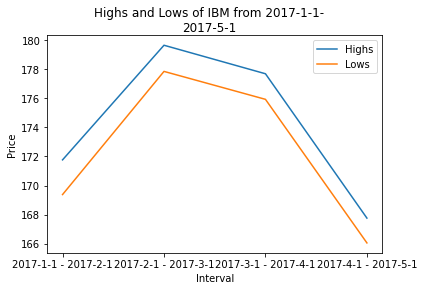

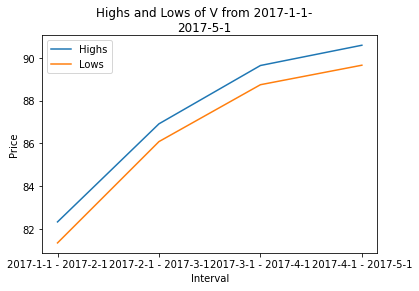

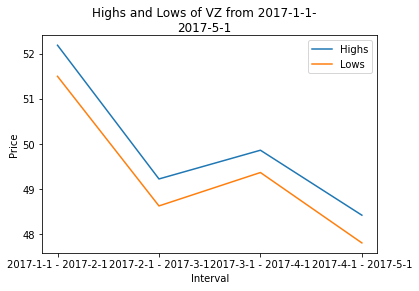

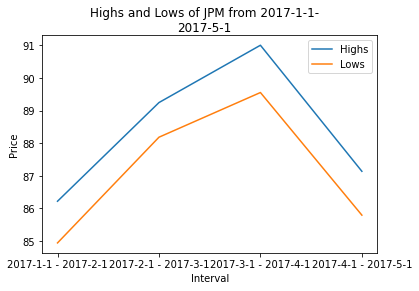

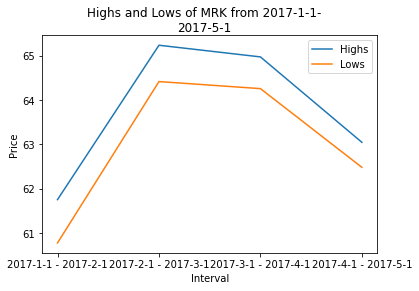

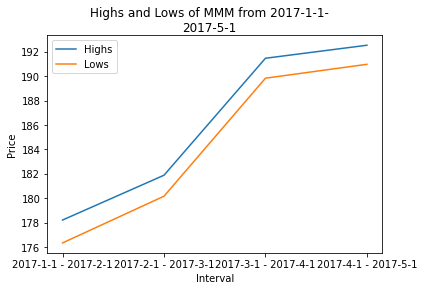

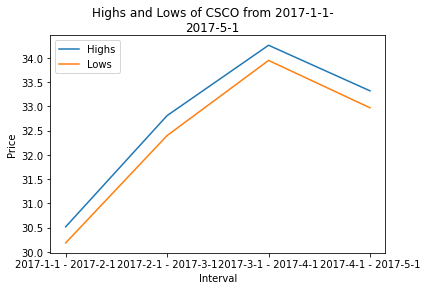

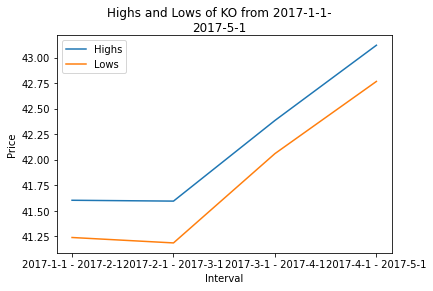

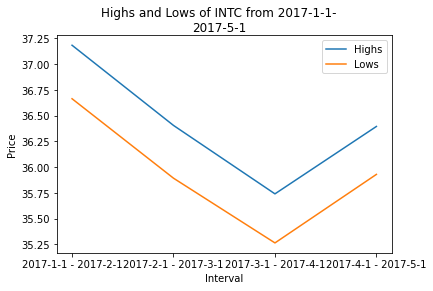

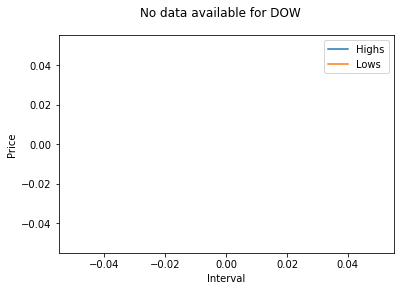

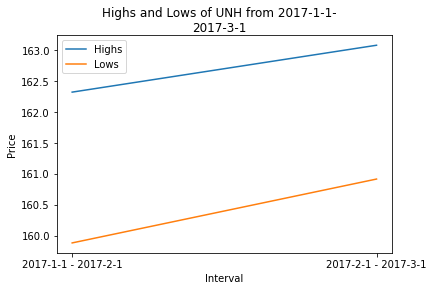

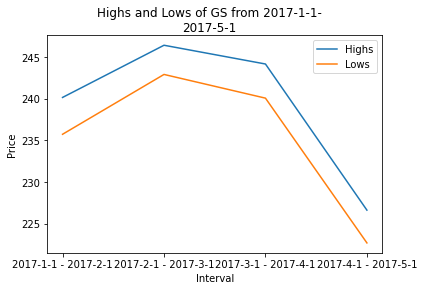

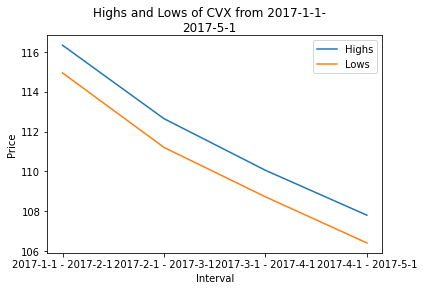

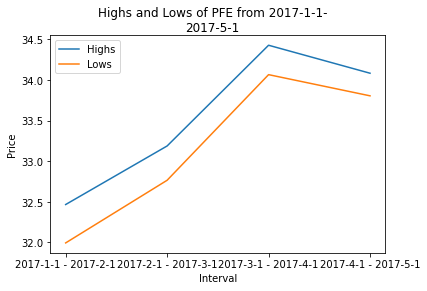

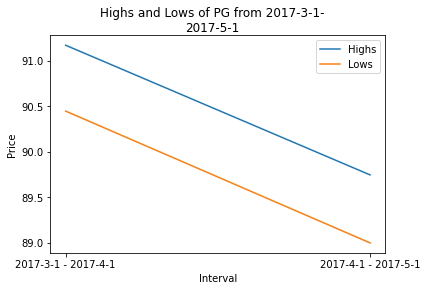

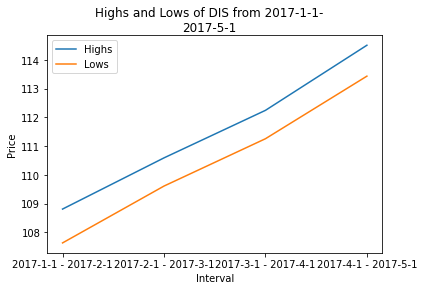

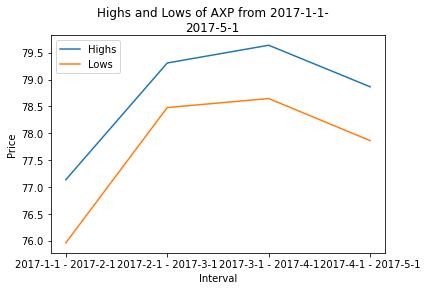

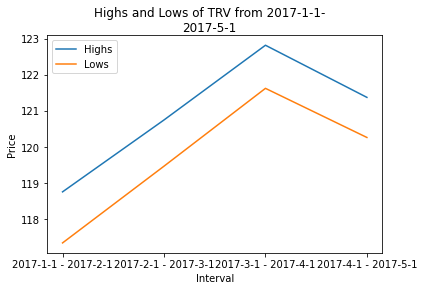

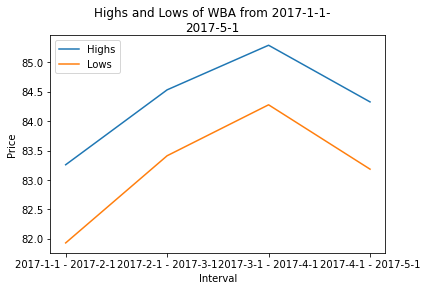

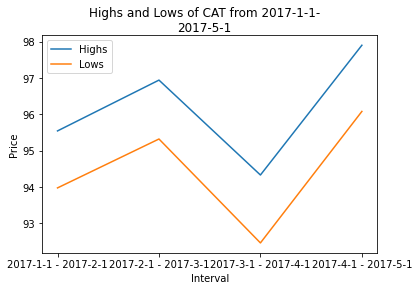

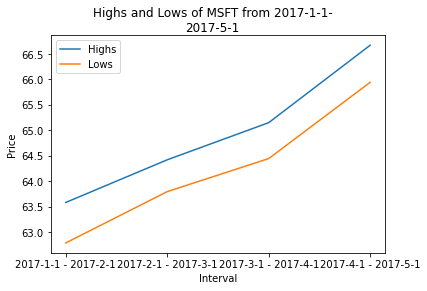

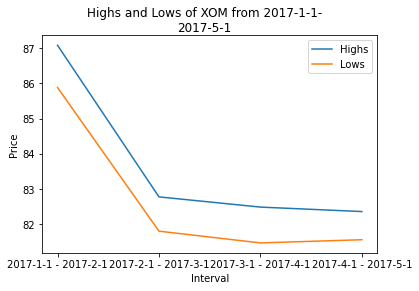

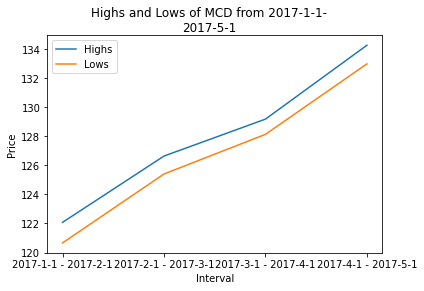

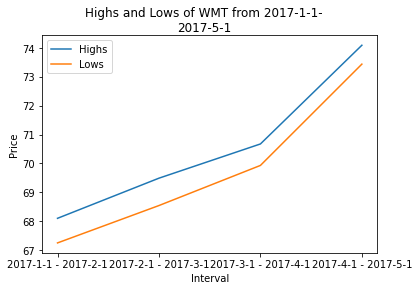

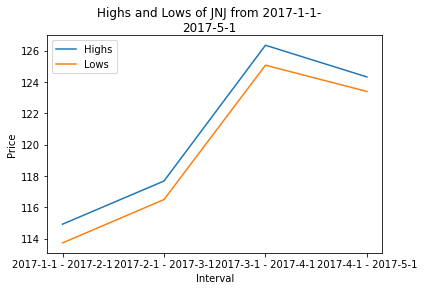

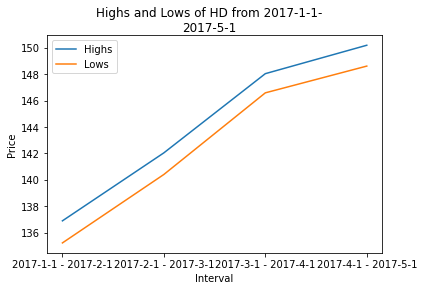

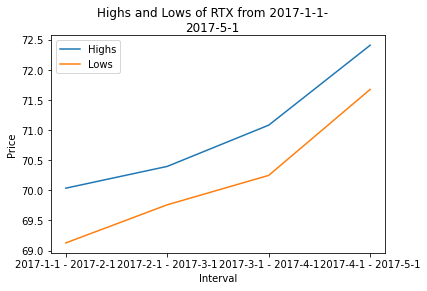

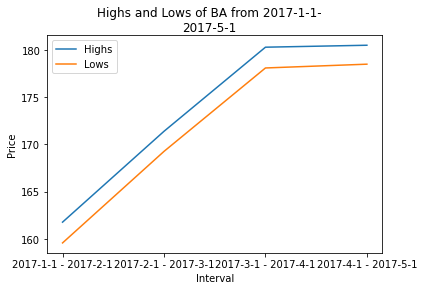

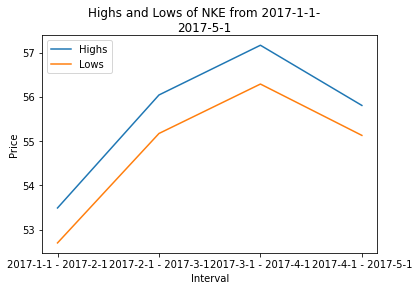

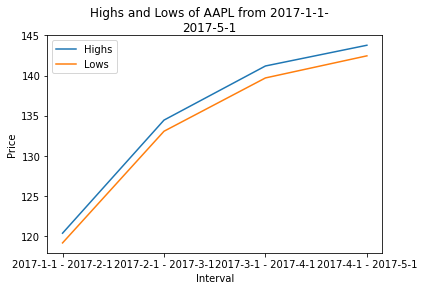

In [76]:
plot_highs_and_lows_for_all_dow_30("2017-01", "2017-05", 1)